# Data Clinic: MTA Accessibility hack day

## Setup

Welcome to the tutorial for the Q4 data clinic hack day focusing on Accessibility on the MTA. Today we are going to:

1. Walk you through how to load in the data you will need for the hack day
2. Generate some high level descriptive statistics from that data 
3. Make plots over time and space that will help understand the general patterns in the data 
4. Make calls to the MTA route planning API to get the easiest route from a starting location to end location 

Before we start though, let's make sure we are set up to allow you to access all the packages we are going to need for this tutorial.

First lets make sure we are on the correct Beaker X server and are working with the correct environment.

First take a look at the URL bar in your browser. It should start with **http://beakerx-beta.app.twosigma.com**, if it says something other than that try clicking this link [http://beakerx-beta.app.twosigma.com](http://beakerx-beta.app.twosigma.com). 

Next let's make sure you are on the correct kernel. Simply go to the **Kernel** menu at the top of this page, hover over the **Change kernel** and select the **Python [conda env:data-clinic]** option.

Once you have done that, try running the next cell. If there are any errors ask one of the Data Clinic staff to help you!


In [1]:
import pandas as pd 
import geopandas as gp
import altair as alt 
import gpdvega 
import json
import matplotlib.pyplot as plt
alt.renderers.enable('notebook') # render for Jupyter Notebook

DATA_DIR = '/nas/dft/ire/stuartlynn/MTA_ACCESSIBILITY/MTAAlertScraper-master/data/'

If that all worked, we should be good to start exploring the data!

## Data exploration

There are a number of datasets available for this hack day. They are all stored in a network drive that you should have access to. For convenience, let's list them all here with a brief description before we dive into how to use each. 

- **Subway Lines.geojson** : This file contains each of the subway lines as a geojson file. It will primarily be useful to make maps of the data. 
- **Subway Stations.geojson** : This file contains each of the subway stations as a geojson file. It will primarily be useful to make maps of the data. 
- **turnstile.pkl.gz** : This file contains the hourly counts of people entering and exiting turnstiles at MTA stations in 2018 - 2019. 
- **EE_master_list.csv**  : This file contains the master list of equipment (escalators and elevators). 
- **all_alerts.csv.gz** : This file contains every alert the MTA has sent out in 2018 and 2019. This is here in case you want to go back to the source data however the **outages.csv.gz** file contains the results of processing the alert data into specific outages of equipment. We encourage you to use the **outages.csv.gz** file.
- **outages.csv.gz** This file contains equipment outages from 2018 and 2019. 
- **subway_turnstile_join.csv** This file contains the same information as the **Subway Stations.geojson** file but is also joined to the turnstile data to allow easier plotting of exit and entry rates. 

let's now take a look at each dataset and how to load them.


### Geospatial data

Let's start with the geospatial data as this is probably the least familiar type of data for most people. To load it, we are going to use a variation on pandas called geopandas. As you might guess from the name, geopandas gives us a dataframe that allows columns to hold geospatial information such as lines, polygons, points etc. 

To load in a file, we simply call gp.read_file() passing in the location of the file. Let's first load in the subway station data.


In [2]:
stations = gp.read_file(DATA_DIR+'Subway Stations.geojson')
stations.head()

So the stations dataframe will look familiar to anyone who has used pandas before with the exception of the geometry column which contains the location of each station. Let's next make sure the data looks right by plotting it. This is pretty straightforward to do using geopandas plot function. 


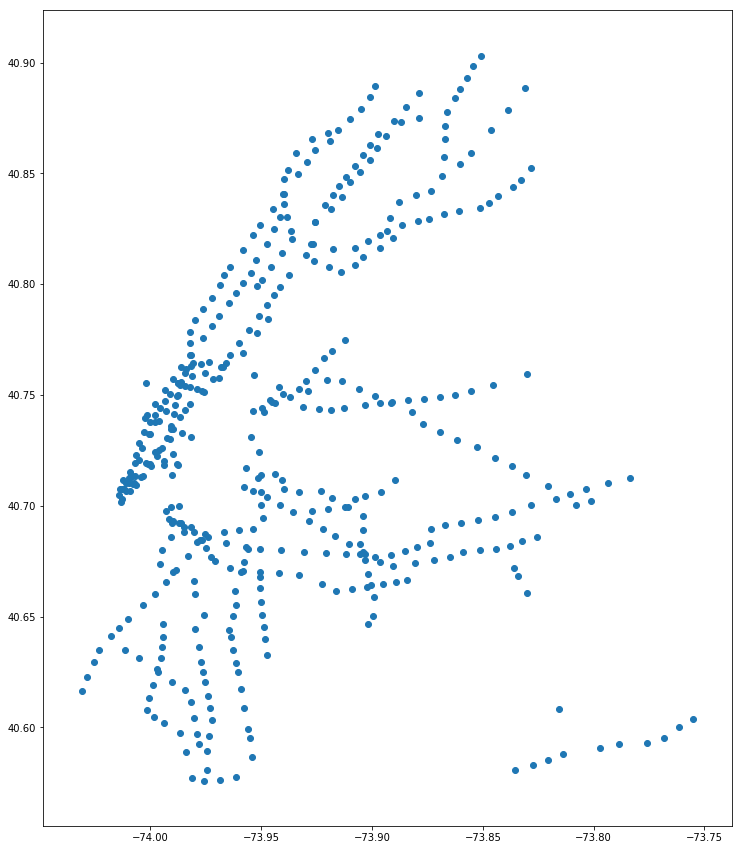

In [3]:
stations.plot(figsize=(15,15))


Great that looks like the New York city we know and love. Next let's bring in the line data, it's exactly the same process so I will leave this as an  exercise for you to do! 

**EXERCISE** 
1. Load in the **Subway Lines.geojson* file
2. What kind of geometry column does this file have?
3. Plot the lines on a map
4. Try passing the option _column='name'_ to the plot command, what does that do? 


In [3]:
lines = gp.read_file(DATA_DIR+'Subway Lines.geojson')

In [4]:
lines.head()

finally let's combine the station and line data into one map. Assuming you loaded the line data into the variable line then the following should just work

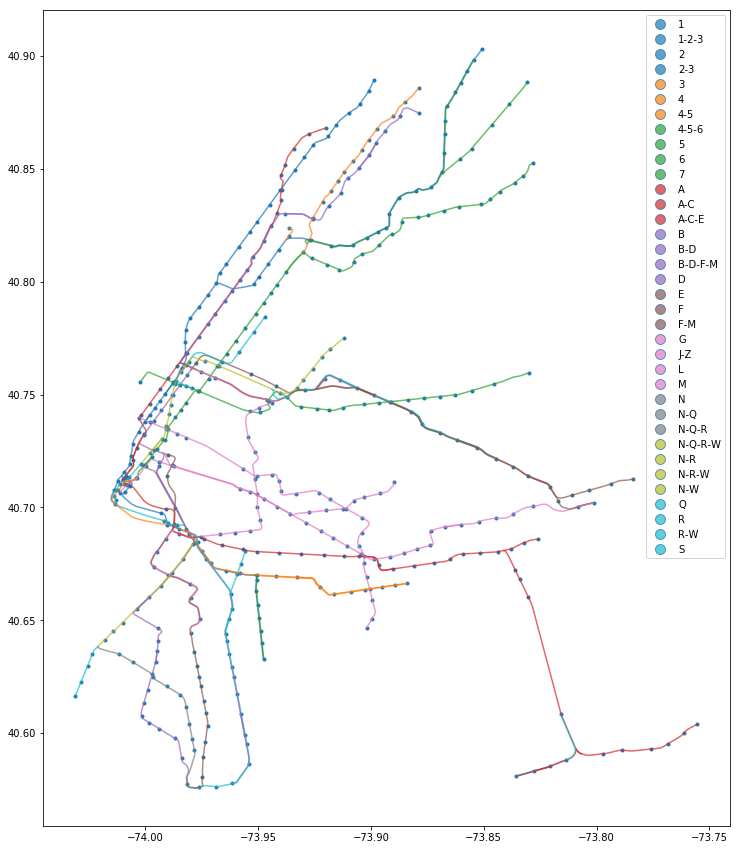

[23:59:14.418 WARNING] metrics POST metric-py3-2019.12.03: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))


In [5]:
fig, ax = plt.subplots(figsize=(15,15))
lines.plot(ax=ax, column='name', legend=True, alpha=0.7)
stations.plot(ax=ax, markersize=9)

beautiful!

### Turnstile data

Ok so now that we have the ability to make some simple maps, let's actually bring in some data. We will start with the turnstile data which we will load in using pandas

In [6]:
turnstile = pd.read_pickle(DATA_DIR+"turnstile.pkl.gz")

In [7]:
turnstile.head()

The important columns here are 

1. Station : The station that the turnstile is located at. Stations have multiple turnstile units
2. UNIT: Combined with SCP, this column defined a unique identifier for the turnstile 
3. SCP: Combined with UNIT, this column defined a unique identifier for the turnstile 
4. datetime: The 4 hour period that the count was taken for. These do not necessarily line up across turnstiles
5. ENTRIES: The cumulative number of people who entered the turnstile, this number resets when it hits some max amount
6. EXITS: The cumulative number of people who exited the turnstile, this number resets when it hits some max amount
7. entry_diff: The number of people to enter in this 4 hour period
8. exit_diff: The number of people who exited in this 4 hour period



We can slice and dice this data to ask some basic questions of it. For example, let's look at how many people entered Canal Street station on the first of March 2018. To do this, we need to first filter by the station and the day and then sum up the entries and exits. 

In [8]:
(turnstile.loc[ (turnstile.STATION=='CANAL ST')        # Filter by station 
                & (turnstile.datetime=='2018-03-01')   # Filter by day 
               , ["entry_diff",'exit_diff']]           # Just grab the entries and exits columns
          .sum())                                      # Sum entries and exits for all turnstiles

entry_diff    5757.0
exit_diff     1861.0
dtype: float64

**EXERCISE** 
1. Find your own station 
2. Pick a date range and calculate the number of entries and exits


Let's next plot out a week's worth of data for a particular station: 14th Street.

In [10]:
turnstile.head()

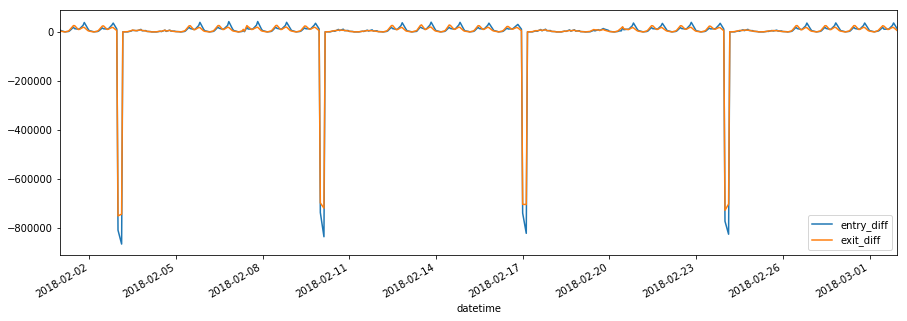

In [11]:
grand_central_feb = turnstile[turnstile.STATION =='GRD CNTRL-42 ST'].set_index('datetime').loc['2018-02-01': '2018-03-01']
grand_central_feb.groupby(grand_central_feb.index.floor('h')).sum()[['entry_diff','exit_diff']].plot(figsize=(15,5))

This looks a bit weird... we shouldn't have such large dips in the data. The reason we see this is because this is when the turnstile counters reset. An exercise for the hack day might be to figure out how to handle these situations but for now let's remove anything that is negative from our time series.

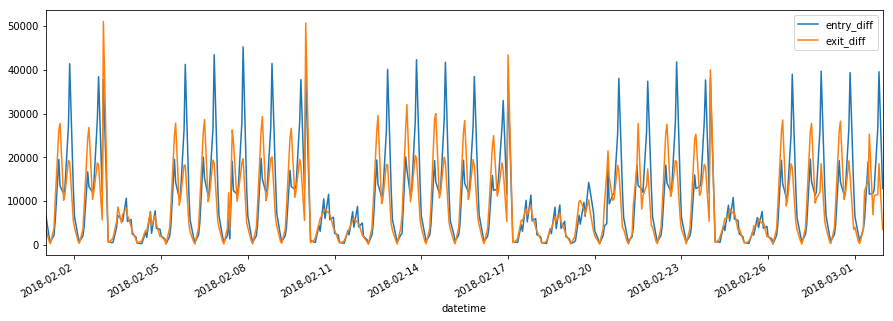

In [14]:
grand_central_feb = turnstile[turnstile.STATION =='GRD CNTRL-42 ST'].set_index('datetime').loc['2018-02-01': '2018-03-01'] # filter by station and date range
grand_central_feb = grand_central_feb.loc[ (grand_central_feb.exit_diff > 0) & (grand_central_feb.entry_diff > 0)]         # filter only positive entry and exit values
(grand_central_feb.groupby(grand_central_feb.index.floor('h')).sum()[['entry_diff','exit_diff']]                           # group by hour and sum
                  .plot(figsize=(15,5)))                                                                                   # plot the results

That looks better! We can clearly see the difference between weekdays and weekends and the daily pattern of people entering and exiting the station. 

**EXERCISE** 
1. Find a station where the weekly exits are greater than the entries
2. Plot the pattern of entries and exits for that station


Next let's try and join the data to the subway stops to see what the pattern looks like when viewed with the transit system as a whole. First let's generate daily station counts

In [15]:
valid_turnstile = turnstile[(turnstile.entry_diff.abs() < 3000) & (turnstile.exit_diff.abs() < 3000)]        # Get rid of outliers
daily_station_counts = valid_turnstile.groupby(['STATION','LINENAME', valid_turnstile.datetime.dt.floor('d')]).sum()[[    # Group by station and day and sum
    'entry_diff',                                                                                              # Select only the entry and exit columns
    'exit_diff'
]].reset_index()                                                                                               # Reset the index

Unfortunately, the station names that are used by the MTA for the turnstile data are not the same as the ones in the station geojson file. We have done some work combining the two datasets but it's not 100% complete, this is something we will have to work on at hack day a little. For now let's load in the subway_turnstile_join data to be able to do some mapping.

In [16]:
from shapely import wkt

subway_turnstile = pd.read_csv(DATA_DIR+'subway_turnstile_join.csv')
subway_turnstile['geometry'] = subway_turnstile['geometry'].apply(wkt.loads)

In [17]:
subway_turnstile.head()

In [18]:
geo_joined_daily_data = gp.GeoDataFrame(
     pd.merge(
        daily_station_counts,
        subway_turnstile, 
        left_on=['STATION', 'LINENAME'],
        right_on=['station','line_name']
    ).set_index('datetime')
)

In [19]:
geo_joined_daily_data.head()

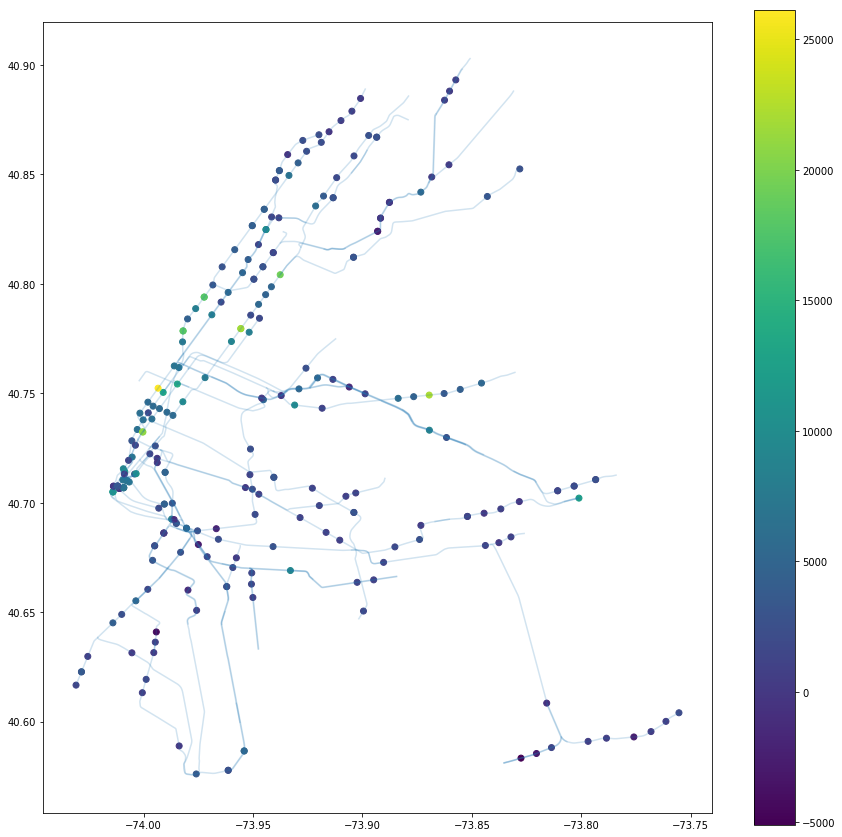

In [20]:
fig,ax = plt.subplots(figsize=(15,15))
lines.plot(ax=ax, legend=True, alpha=0.2)
geo_joined_daily_data.loc['2018-09-01'].plot(column='exit_diff', ax=ax, legend=True)

**EXERCISE** 
1. Produce a map of the average morning entries and exits vs evening entries and exits



### Outage data

One of the key datasets we have to work with is the outage data,  this is actually derived from the MTA Alert database which can be found here: ADD LINK TO WEBSITE.

We have downloaded this data and extracted a lot of useful information from it. You can access it in two ways: 

1. The raw alert data 
2. The cleaned outage report data.

Let's start with the alert data. You can load it in as follows:


In [21]:
all_alerts = pd.read_csv(DATA_DIR+'all_alerts.csv.gz')
all_alerts['Date'] = pd.to_datetime(all_alerts['Date'], format='%Y-%m-%d %H:%M:%S')
all_alerts.head()

[00:02:56.229 WARNING] /nas/dft/ire/tsbeakerx/.conda/shared-envs/data-clinic/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,5,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Let's look at each of these columns. The first 4 are the ones we get directly from the MTA Alert database:

- 'Date' : The date and time the message was sent.
- 'Agency': The agency that sent the message (MTA, LIRR etc)
- 'Subject': The subject of the message 
- 'Message Sent': The body of the message
  
The remaining columns are ones that we have populated using some regular expressions and are useful for filtering, etc.
    
- 'equipment_no_from_subject' : the id of the elevator or escalator extracted from the subject
- 'equipment_no_from_message' : the id of the elevator or escalator extracted from the message body
- 'outage' : True or False, is this message about an outage
- 'back_in_service', : True of False is this message informing us that the equipment is back in service
- 'planned_outage', : Was this a planned outage ?
- 'planned_start_time' : If it is a planned outage what is the start time of the outage (extracted from message body)
- 'planned_end_time':  If it is a planned outage what is the end time of the outage (extracted from message body)
- 'equipment_type': Is this message about an escalator or an elevator?
- 'alert_type' : type of alert ('other', 'outage', 'restore', 'planned')
- 'planned_start_date': If it is a planned outage what is the start date of the outage (extracted from message body)
- 'planned_end_date': If it is a planned outage what is the end date of the outage (extracted from message body) 
- 'station_name': The name of the station where the equipment is located

We advise hack day attendees to focus on the cleaned outage data rather than the alerts file but let's make some basic plots to see what the alerts look like over time.


Text(0.5,1,'All Alerts')

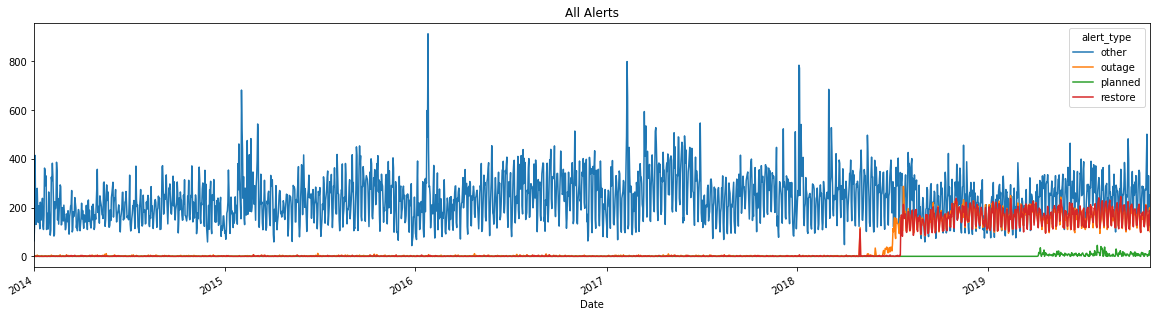

In [22]:
#Simple function to plot alert time series binned by some category.
def plot_time_series(df,category=None):
    if(category):
        return (df.groupby([category, df.Date.dt.floor('d')])
            .count()
            .drop(['Date'],axis=1)
            .reset_index()
            .pivot_table(columns=category,index='Date',values='Agency' )
            .fillna(0)
            .plot(figsize=(20,5)))
    else:
        return df.groupby(df.Date.dt.floor('d')).count().elevator.plot()
        
ax = plot_time_series(all_alerts,category='alert_type')
ax.set_title("All Alerts")

As we can see, alerts about equipment outage and restoration only really started being sent out during the later half of 2018 and planned outages don't show up in the data until half way through 2019. Let's zoom in on 2019 to take a closer look at the data

Text(0.5,1,'Elevators')

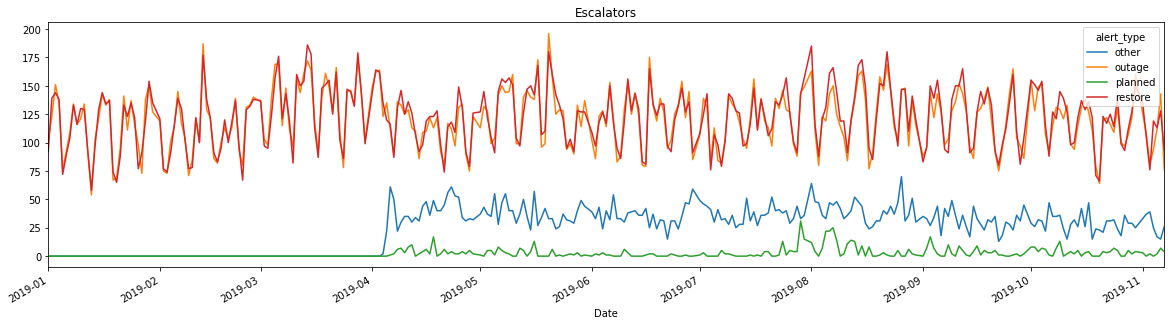

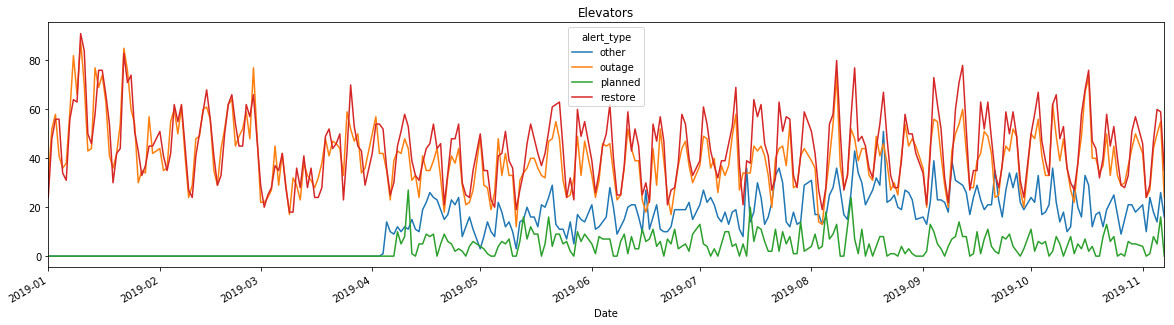

In [23]:
ax = plot_time_series(all_alerts[ (all_alerts.equipment_type=='escalator') & (all_alerts.Date.dt.year==2019) ],category='alert_type')
ax.set_title("Escalators")

ax = plot_time_series(all_alerts[(all_alerts.equipment_type=='elevator') & (all_alerts.Date.dt.year==2019)],category='alert_type')
ax.set_title("Elevators")

This looks good for 2019 at least. We see that the number of outage alerts traces the number of restore alerts as we would hope. It's useful to keep in mind during this analysis that specifically planned outages might not be reported before 2019-04. 

We can also look at outages for each piece of equipment

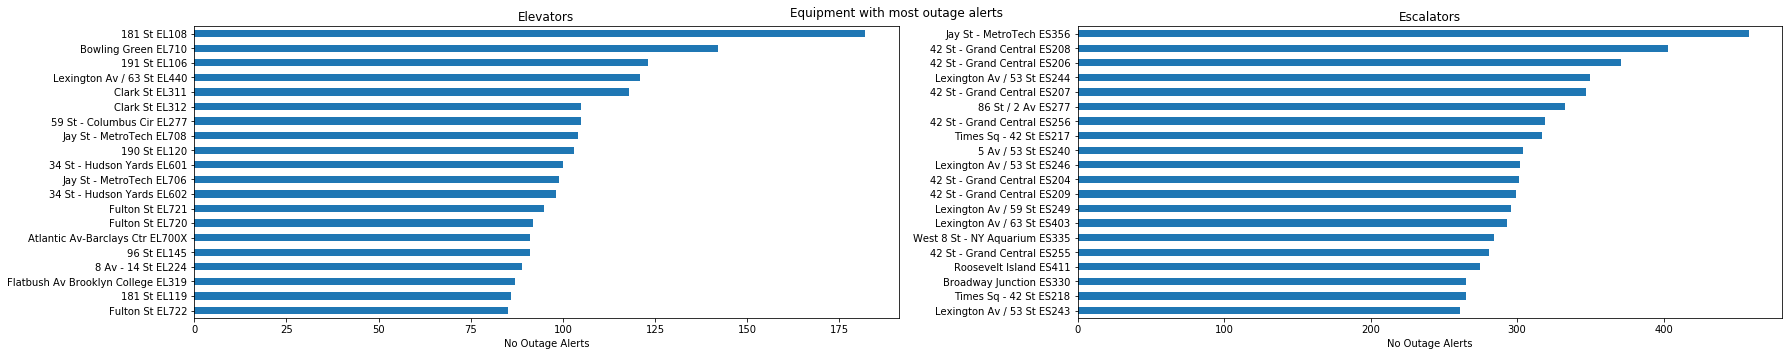

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,5))

data_2019 = all_alerts[all_alerts.Date.dt.year==2019]
data_2019 = data_2019.assign(name_and_eid = data_2019.station_name + " " +  data_2019.equipment_no_from_message)
data_2019[data_2019.outage & (data_2019.equipment_type=='elevator')].groupby("name_and_eid").count().Date.sort_values(ascending=True).tail(20).plot(kind='barh', ax=axs[0])
data_2019[data_2019.outage & (data_2019.equipment_type=='escalator')].groupby("name_and_eid").count().Date.sort_values(ascending=True).tail(20).plot(kind='barh',ax=axs[1])

axs[0].set_title("Elevators")
axs[1].set_title("Escalators")

axs[0].set_xlabel("No Outage Alerts")
axs[1].set_xlabel("No Outage Alerts")

axs[0].set_ylabel('')
axs[1].set_ylabel('')
plt.suptitle('Equipment with most outage alerts')
plt.tight_layout()

It's interesting to note that there are way more alerts about outages on escalators than elevators.

**EXERCISE** 
1. Select a specific station from the alert data 
2. Look at the messages sent for equipment in that station in 2019
3. Figure out which piece of equipment in that station is the most prone to breakdowns

While it's interesting to look at the alert data raw, it can be hard to establish clear trends. To make it easier we have done some work to extract, event types that correspond to outages and created a dataset of these outages and their durations.

Let's load that dataset up and see what it looks like



In [25]:
outages = pd.read_csv(DATA_DIR+"outages.csv.gz" )
outages['Outage start'] = pd.to_datetime(outages['Outage start'], format='%Y-%m-%d %H:%M:%S')
outages['Outage end'] = pd.to_datetime(outages['Outage end'], format='%Y-%m-%d %H:%M:%S')

outages.head()

The columns in the file are the following: 
    
- Agency: The agency that sent out the alert. 
- Initial alert subject: The initiating alert subject
- Initial message sent: The initiating alert message 
- Equipment number: The id of the elevator or escalator which experienced the issue
- Planned outage: If the outage was planned or not 
- Equipment type: Escalator or Elevator
- Final alert subject: The concluding alert subject. We consider the final alert to be the one that indicates that the equipment is back in service
- Final message sent: The concluding alert message. We consider the final alert to be the one that indicates that the equipment is back in service
- Duration: The duration of the outage in hours. For unplanned outages this is measured from the alert where the outage is reported to the alert that says it's back in service. For planned outages, we take the duration to be the time between the reported planned start time of the outage and the time of the alert that declares it back in service
- Outage start: Datetime of the beginning of the outage, taken to be the time of the alert that states equipment is broken or the reported start time of planned outages
- Outage end: Datetime of the alert that declares the equipment to be back in service

The MTA classifies how good or bad a piece of equipment is by calculating the total amount of time it was functioning divided by the total time it was in operation. To start to dig in to this metric, it's useful to show a calendar view of a piece of equipment an how long on each day the equipment was not functioning for. To do this we will use a new plotting library called [Altair](https://altair-viz.github.io).

Altair is useful because it gives us the ability to make interactive plots that can be exported to javascript and embedded on websites. This will be useful for hack day when we want to present our results. 

Let's use altair to make a heat map of outages for the worst elevator in our system EL700X. We start by creating daily outage data which sums up the outage time by day and equipment type.


In [26]:
daily_data = (outages.groupby(['Equipment number', 'Station',outages['Outage start'].dt.floor('d')])
                    .Duration.sum()
                    .reset_index()
                    .assign(day = lambda x: x['Outage start'].dt.day, month = lambda x: x['Outage start'].dt.month)
                    .set_index('Equipment number'))


daily_data.head()

One limitation that you might want to try and improve on at the hack day is that we currently assign all of the outage time to the day on which the outage started. This is obviously wrong if the outage spans two days. 

**EXERCISE** 
1. Find a way to compensate for the split outages


For now we can create a little function to plot a calendar of outages for a specific elevator

In [27]:
daily_data.loc['EL700X'].Station.iloc[0]

'Atlantic Av-Barclays Ctr'

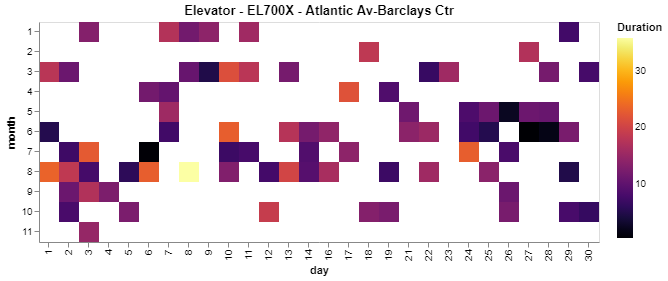

In [28]:
def heat_chart_for_equipment(equipment_id, station):
    return alt.Chart(daily_data.loc[equipment_id], title="{} - {} - {}".format( 'Escalator' if 'ES' in equipment_id else "Elevator", equipment_id, station )).mark_rect().encode(
      x='day:O',
      y='month:O',
      color=alt.Color('Duration', scale=alt.Scale(scheme="inferno")),
    #   stroke=alt.Color('rgab(255,255,255,1)'),
      tooltip=[
        alt.Tooltip('Duration',title="duration"),
        alt.Tooltip('day',title="day"),
        alt.Tooltip('month',title="month")
      ]
    ).configure_mark(strokeWidth=0)
heat_chart_for_equipment('EL700X', 'Atlantic Av-Barclays Ctr')

We can do a similar thing with the turnstile data to see how busy the station was during these outages

In [29]:
atlantic_ave = turnstile[ (turnstile.STATION=='ATLANTIC AV') &  ( turnstile.datetime.dt.year==2019)]
turnstile_data_by_day = atlantic_ave[ (atlantic_ave.entry_diff.abs() < 2000) & (atlantic_ave.exit_diff.abs() < 2000) ] .assign(day=atlantic_ave.datetime.dt.day, month = atlantic_ave.datetime.dt.month).groupby(['day','month']).sum()[['entry_diff', 'exit_diff']].reset_index()

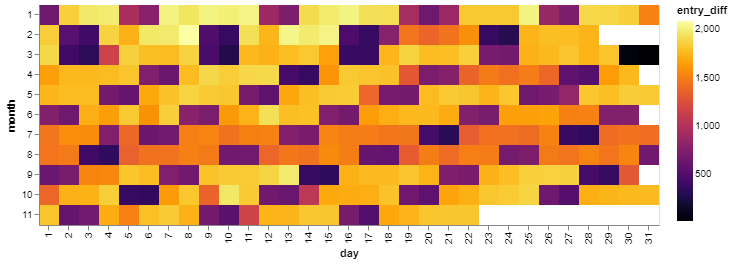

In [30]:
alt.Chart(turnstile_data_by_day).mark_rect().encode(
      x='day:O',
      y='month:O',
      color=alt.Color('entry_diff', scale=alt.Scale(scheme="inferno")),
    #   stroke=alt.Color('rgab(255,255,255,1)'),
      tooltip=[
        alt.Tooltip('entry_diff',title="No of entries"),
        alt.Tooltip('day',title="day"),
        alt.Tooltip('month',title="month")
      ]
    ).configure_mark(strokeWidth=0)

As we can see there are clearly days when an outage is more problematic than others. 

This is something we want to explore in the hack day, can we come up with a better metric for how important an outage is? Somethings we want to look at: 

1. How many people entered or exited the station during each outage
2. How disruptive is an outage. For stations with only a single elevator, an outage will make that entire station inaccessible. Alternatively if a station has two elevators and they are both out at the same time, that also represents a more serious problem than a single elevator being out.


**EXERCISE** 
Following the example of the turnstile data, can you join the outage data with the map. To do this break it down into steps:
1. Calculate the total outage per station for a given day. You can either consider this as the total down time of elevators or the amount of time the station had at last 1 elevator out of service.
2. Join the station data to the counts of outage per day per station.
3. Plot the points colored by outage level and add in the lines for context.

## Trip focus 

Even if we produce a better metric for the impact of an elevator outage, it still doesn't really capture the experience of real people on the MTA. Most of our interactions with the MTA involve a trip with multiple stations rather than just a single station. The other goal of the hackathon is to be able to estimate the effect of outages on a given trip. To do this, we need to be able to do the following two things: 

1. Given a starting point, end point, and a time of day, list the stations and transfers that are required to make that trip.
2. Understand what connections for that trip (elevator from entrance to platform, transit between platforms, etc.) are affected by outages.


The first of these we can get by using the MTA Trip planner tool. This tool allows you to enter a start location and an end location and get the proposed planned route between each. The following function should help you with making the request and getting back data from the trip planner


The construct routes function has the following arguments 

- start_station : a row from the stations dataframe that represents the starting location for a trip. So for example stations.iloc\[0\] or $stations.iloc\[1\] 
- end_station : a row from the stations dataframe that represents the final location for a trip. So for example stations.iloc\[20\] or stations.iloc\[21\]
- date: the date of the trip
- time: the time of the trip
- wheelchair: if the route should be wheelchair accessible

It returns an array of possible itineraries for the trip which contains a lot of information you can dig into during hack day! 


In [186]:
import ts.http
from urllib.parse import urlencode 

# Date is in the format %m/%d/%ylike 11/27/19 
# Time is in the format %I:%M %p like   04:03 PM

def construct_routes(start_station, end_station, date ,time, wheelchair):
    start_lng = start_station.geometry.x
    start_lat = start_station.geometry.y
    
    end_lng = end_station.geometry.x
    end_lat = end_station.geometry.y 
    
    
    start = "{} {}".format(start_lat, start_lng)
    end   = "{} {}".format(end_lat, end_lng)
    
    base_url='https://otp-mta-prod.camsys-apps.com/otp/routers/default/plan?apikey=Z276E3rCeTzOQEoBPPN4JCEc6GfvdnYE'
    options= {
        "allowUnknownTransfers":False,
        "mode":"TRANSIT,WALK",
        "numItineraries":3,
        "showIntermediateStops":True,
        "smartKissAndRide":True,
        "flagStopBufferSize":50,
        "nextDepartureWindow":86400,
        "toPlace":end,
        "fromPlace":start,
        "arriveBy":False,
        "wheelchair":wheelchair,
        "maxWalkDistance":8004,
        "date":date,
        "time":time,
        "optimize":"TRANSFERS",
        "bannedAgencies":"",
        "bannedRouteTypes":702
    }
    
    options= urlencode(options)
   
    session = ts.http.Session()

    r =session.get(base_url+"&"+options)
    r.raise_for_status()
    result = r.json()
    if('error' in result.keys()):
        print('Failed to get route ', result['error'])
    else:
        return r.json()['plan']['itineraries']
    
def print_instructions(itin):
    for leg in itin['legs']:
        mode = leg["mode"]
        print("Mode : ",mode , leg['route'] + ' train' if 'route' in leg.keys() else '', leg['duration']/60.0 , " minutes")
        if(mode =='SUBWAY'):
            print("    ", leg['from']['name'], "->", leg['to']['name'])
        for step in leg['steps']:
            print("    "+step['instructionText'])

To get a feel for what data comes back, let's run a route between two random stations in our dataset

In [184]:
route_wheelchair = construct_routes(stations.iloc[0], stations.iloc[30], "12/04/19", '04:03 PM',True)
route = construct_routes(stations.iloc[0],stations.iloc[30], "12/04/19", '04:03 PM', False)

In [222]:
print("Wheelchair accessible ",route_wheelchair[0]['duration']/60.0, ' Mins')
print("---------------------\n")
print_instructions(route_wheelchair[0])

print("\n\n")
print("Non Wheelchair accessible ",route[0]['duration']/60.0, ' Mins')
print("---------------------\n")
print_instructions(route[0])

Wheelchair accessible  12.283333333333333  Mins
---------------------

Mode :  WALK  train 8.116666666666667  minutes
    Start on East 8th Street heading northwest
    Right on to Lafayette Street
    Continue on to 4th Avenue
    Left on to East 14th Street
    Left on to Broadway
    Enter station using elevator, slightly left [Uptown & The Bronx]
    Continue to 5 [Uptown & The Bronx]
Mode :  SUBWAY 5 train 4.0  minutes
     14 St - Union Sq -> Grand Central - 42 St
Mode :  WALK  train 0.16666666666666666  minutes
    Exit station using elevator
    Left on to East 42nd Street



Non Wheelchair accessible  8.933333333333334  Mins
---------------------

Mode :  SUBWAY 6 train 7.5  minutes
     Astor Pl -> Grand Central - 42 St
Mode :  WALK  train 1.4333333333333333  minutes
    Exit station using stairs
    Hard left on to East 42nd Street


Even with this simple example we can see that even with functioning elevators, people with mobility challenges have to go out of their way to reach their destination. The journey that requires an elevator includes a walk of 8 minutes and is about 3 and a half minutes longer.

We can ask the question, what if the elevator at 14 St - Union Sq was not working? Can we use historical or simulated outages to see just how much worse peoples commutes are compared to those who do not have to rely on elevators?


## Projects

Having concluded this tutorial and having completed the examples above, you should be in a good place to help out at the hack day. We are focusing on two specific projects that we have tried to sketch out in this notebook. The two projects we are going to be working on in teams are the following:


### Project 1: Global picture
- Develop a better metric of impact than the one currently used
- Take into account the potential number of people impacted from turnstile data
- Take into account vulnerable populations close to the station

### Project 2: Commute impact
- Take 2-3 common commuting routes and estimate the variation in times that a person with limited mobility encounters vs. those who are not reliant on elevators
- Using historical data, work out delays due to elevator outages 
- Identify trips that would have an alternative route and the extra time these take 
- Identify trips that become impossible



## Other data sources

While not covered in this tutorial, we can also have access to the following datasets for the hack day itself 

1. Census data about the number of people who have ambulatory disabilities, families with small children, and older adults. 
2. GTFS data for 2018 and 2019 which has the times of each train trip during that period. This is a pretty big dataset and is hard to work with but if you feel up to the challenge, it could be very useful!
